## Importing Libraries

In [1]:
%load_ext autoreload
%autoreload

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Reshape,Flatten,UpSampling2D,concatenate, Activation

import numpy as np
import matplotlib.pyplot as plt

from constants import INPUT_SHAPE, class2label
from conversion import get_class2color, FloorplanRaw, FloorplanSVG, read_room2class_condensed

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.metrics import *

from tensorflow.keras.models import model_from_json

import keras_segmentation

In [34]:
from lxml import etree
import pdb
import re
from xml.dom import minidom
import pdb
from skimage.draw import polygon
import cv2
import pandas as pd
from skimage import measure
import scipy
from scipy import ndimage

import imagesize

## Problem Definition

Our goal for this project is to study how well models with different and simpler model structures such as the ‘U-net’ model perform in comparison to the multi-task model used in paper in predicting wall positions and room types. We also plan to explore how knowing the positions of walls might help training models predicting room labels.

After reading through the paper on `CubiCasa5k` which builds upon `Raster-to-Vector`, we find that the paper already did a good job in predicting room structures and labels accurately using a pipelined multi-task model. Nevertheless it used multi-task CNN to do many tasks such as predicting walls’ positions and room types separately. Thus, on the one side, we want to explore if other single-task models could produce similar results; on the other hand, we identify that these two tasks can be related because knowing where the walls are should provide information about the rooms which help predicting room types accurately. Following this intuition, we also decided to build a model taking both raw images and images indicating wall positions as input to predict room type labels and see how that works out. More specifically, we added a weighted loss function that utilizes the extra information.



## Data exploration

As a detailed report of EDA is already written in milestone 2, so we are only including an introduction of features of the dataset that relate to our work most here. 

In [35]:
from os import walk

# Parse image directories
datadir = "./cubicasa5k/"
categories = ["colorful", "high_quality", "high_quality_architectural"]
image_dirs = {cat: None for cat in categories} # list of dir names in each category
for cat in categories:
    path = datadir + cat
    for _, dirnames, _ in walk(path):
        image_dirs[cat] = dirnames
        break

In [36]:
print("Number of floor plans in each category:")
for cat in categories:
    print(f"{cat}: {len(image_dirs[cat])}")

Number of floor plans in each category:
colorful: 276
high_quality: 992
high_quality_architectural: 3732


#### A showcase of sample images

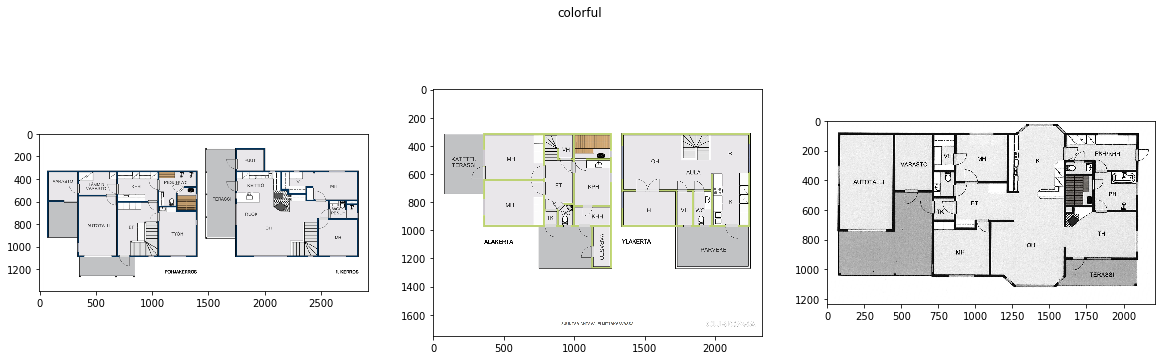

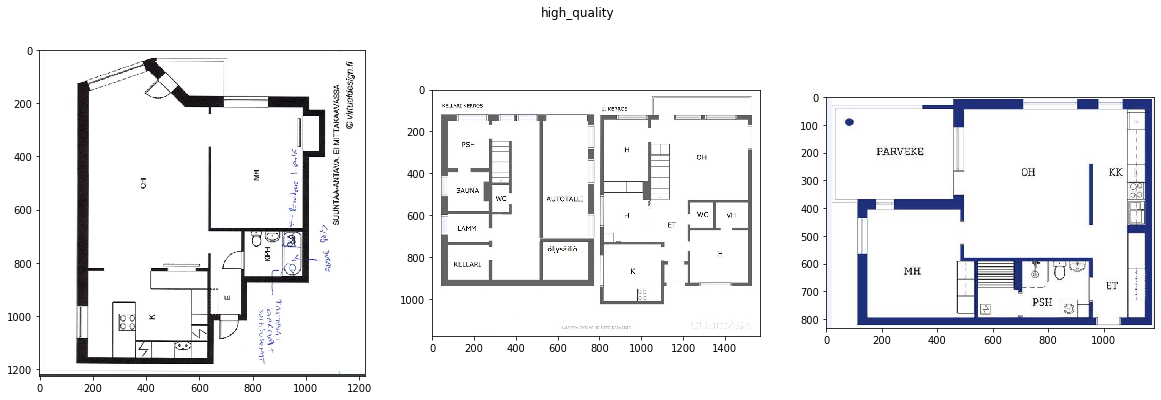

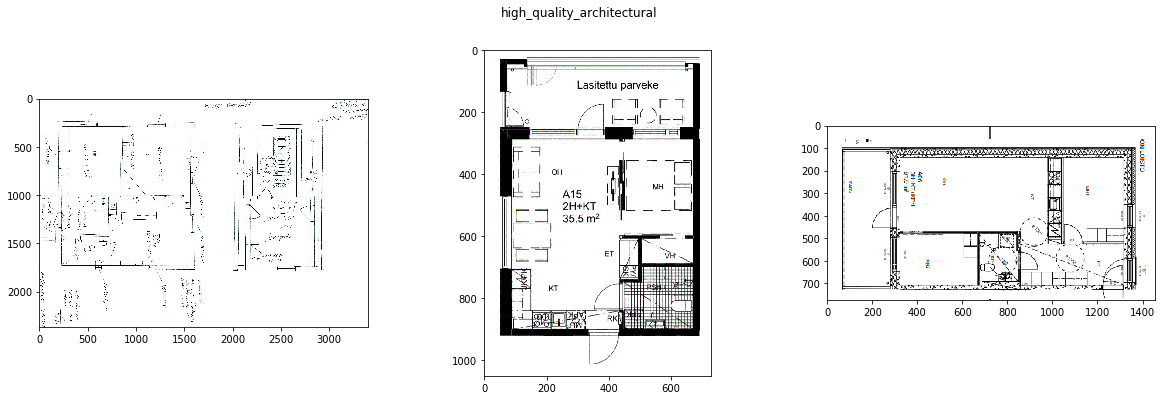

In [37]:
for cat in categories:
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
    fig.suptitle(cat)
    choices = np.random.choice(image_dirs[cat], size=3)
    for i, choice in enumerate(choices):
        fpath = datadir + cat + "/" + choice + "/F1_scaled.png"
        axes[i].imshow(plt.imread(fpath))

## Data Processing

As we need to extract ground truths from svg files, we need some helper functions as listed here. The main one we use is `extract_wall`. When we apply it to a data path, it will read the image and return a tuple, and the first part is the scaled raw image and the second part is a 256\*256 numpy array of zero's and one's where the one's indicate the position of walls.

code developed based on https://github.com/CubiCasa/CubiCasa5k/tree/master/floortrans/loaders

In [2]:
class Wall:
    """Class for representing walls
    """
    def __init__(self, id, end_points, direction, width, name):
        """Store wall with endpoints, directions and widths
        """
        self.id = id
        self.name = name
        self.end_points = end_points
        self.direction = direction
        self.max_width = width
        self.min_width = width

    def change_end_points(self):
        """Change endpoints given directions
        """
        if self.direction == 'V':
            self.end_points[0][0] = np.mean(np.array(self.min_coord))
            self.end_points[1][0] = self.end_points[0][0]
        elif self.direction == 'H':
            self.end_points[0][1] = np.mean(np.array(self.min_coord))
            self.end_points[1][1] = self.end_points[0][1]

    def get_length(self, end_points):
        """Get length between endpoints
        """
        return calc_distance(end_points[0], end_points[1])


class PolygonWall(Wall):
    """
    the polygon icon in .svg file specify the location and room type of each room on a floor map. 
    It gives a few point coordinates for each room. 
    This function connects those points and modify the room type for each pixel.
    """
    def __init__(self, e, id, shape=None):
        """Initialize a polygon wall
        """
        self.id = id
        self.name = e.getAttribute('id')
        self.X, self.Y = self.get_points(e)
        if abs(max(self.X)-min(self.X)) < 4 or abs(max(self.Y)-min(self.Y)) < 4:
            # wall is too small and we ignore it.
            raise ValueError("small wall")
        if shape:
            self.X = np.clip(self.X, 0, shape[1])
            self.Y = np.clip(self.Y, 0, shape[0])
        self.rr, self.cc = polygon(self.Y, self.X)

    def get_points(self, e):
        """Get endpoints
        """
        pol = next(p for p in e.childNodes if p.nodeName == "polygon")
        points = pol.getAttribute("points").split(' ')
        points = points[:-1]

        X, Y = np.array([]), np.array([])
        for a in points:
            x, y = a.split(',')
            X = np.append(X, np.round(float(x)))
            Y = np.append(Y, np.round(float(y)))

        return X, Y


def clip_outside( rr, cc,shape):
    """Since original floormap and the wall images don't align, we resize them so we can train model. 
    """
    s = np.column_stack((rr, cc))
    s = s[s[:, 0] < shape[0]]
    s = s[s[:, 1] < shape[1]]

    return s[:, 0], s[:, 1]


def extract_wall(data_path):
    """Extract wall positions from input data file
    """
    fplan=cv2.imread(data_path+'F1_scaled.png')
    fplan=cv2.cvtColor(fplan,cv2.COLOR_BGR2RGB)
    height,width,nchannel=fplan.shape
    svg=minidom.parse(data_path+'model.svg')
    walls=np.zeros((height,width),dtype=np.uint8)
    wall_id=0
    shape=height,width
    for e in svg.getElementsByTagName('g'):
        try:
            if e.getAttribute("id")=="Wall":
                wall = PolygonWall(e, wall_id, shape)
                wall.rr, wall.cc = clip_outside(wall.rr, wall.cc,shape)
                walls[wall.rr, wall.cc] = 1
                wall_id+=1
            if e.getAttribute("id")=="Railing":
                wall = PolygonWall(e, wall_id, shape)
                wall.rr, wall.cc = clip_outside(wall.rr, wall.cc,shape)
                walls[wall.rr, wall.cc] = 0.1
                wall_id+=1
        except ValueError as k:
            if str(k)=='small wall':
                continue
    
    input_image=cv2.resize(fplan,(256,256))
    wall_target=cv2.resize(walls,(256,256))
    return input_image,wall_target
    

### Prepare Wall Dataset

Since original training data contains 4200 images, the training process takes a very long time even with GPU acceleration. We decide to train on a subset of data. What's shown below is our process to generate such training set with 1500 images, and validation set with 150 images. 

1) Load all resized `png` file (inputs), and extract all the groundtruth images from `svg` file.

In [ ]:
#path
train_path='./cubicasa5k/train.txt' 
val_path='./cubicasa5k/val.txt' 
data_folder='./cubicasa5k'

#load train_x, train_y
data_path=['./cubicasa5k'+i for i in np.genfromtxt(train_path,dtype='str')]
train_X=np.empty((len(data_path),256,256,3))
train_Y=np.empty((len(data_path),256,256))
for i in range(len(data_path)):
    if i %100==0:
        print(i)
    train_X[i]=extract_wall(data_path[i])[0]
    train_Y[i]=extract_wall(data_path[i])[1]

#load val_x, val_y
data_path=['./cubicasa5k'+i for i in np.genfromtxt(val_path,dtype='str')]
test_X=np.empty((len(data_path),256,256,3))
test_Y=np.empty((len(data_path),256,256))
for i in range(len(data_path)):
    if i %100==0:
        print(i)
    test_X[i]=extract_wall(data_path[i])[0]
    test_Y[i]=extract_wall(data_path[i])[1]
    
#save for reuse
outfile = './saved_arrays/train_X.npy'
outfile2 = './saved_arrays/train_Y.npy'
np.save(outfile, train_X)
np.save(outfile2, train_Y)
x_train = np.load(outfile)
y_train = np.load(outfile2)

outfile3 = './saved_arrays/test_X.npy'
outfile4 = './saved_arrays/test_Y.npy'
np.save(outfile3, test_X)
np.save(outfile4, test_Y)
x_test = np.load(outfile3)
y_test = np.load(outfile3)

Process `train.txt`, `test.txt` to generate label list (high-quality, colorful, high-quality-architectural).

In [4]:
class_floor = {0: 'colorful', 1: 'high_quality_architectural', 2: 'high_quality'}
def floor_encode(string):
    
    if 'colorful' in string:
        return 0
    if 'high_quality_architectural' in string:
        return 1
    else:
        return 2

train_path='./cubicasa5k/train.txt' 
category = [floor_encode(i) for i in np.genfromtxt(train_path,dtype='str')]
category[0:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Transform them into numpy array (train_X, train_Y, test_X, test_Y).

In [ ]:
#save and load
outfile = './saved_arrays/train_X.npy'
outfile2 = './saved_arrays/train_Y.npy'
#np.save(outfile, train_X)
#np.save(outfile2, train_Y)
x_train = np.load(outfile)
y_train = np.load(outfile2)

outfile3 = './saved_arrays/test_X.npy'
outfile4 = './saved_arrays/test_Y.npy'
#np.save(outfile3, test_X)
#np.save(outfile4, test_Y)
x_test = np.load(outfile3)
y_test = np.load(outfile3)

Generate index to create subset, and extract corresponding label class.

In [10]:
outfile = './saved_arrays/sub_x_train.npy'
outfile2 = './saved_arrays/sub_y_train.npy'
outfile3 = './saved_arrays/sub_x_test.npy'
outfile4 = './saved_arrays/sub_y_test.npy'

'''How we generate the loaded files
index_train = np.random.randint(0, 4200, 600)
index_test = np.random.randint(0, 400, 50)

sub_label_train = [category[i] for i in index_train]
sub_label_test = [category[i] for i in index_test]

sub_x_train = x_train[index_train]
sub_x_test = x_test[index_test]
sub_y_train = y_train[index_train]
sub_y_test = y_test[index_test]

print(sub_x_train.shape)
print(sub_y_test.shape)


with open("sub_label_train.txt", "wb") as fp:
    pickle.dump(sub_label_train, fp)

with open("sub_label_test.txt", "wb") as fp:
    pickle.dump(sub_label_test, fp)


outfile = './saved_arrays/sub_x_train.npy'
outfile2 = './saved_arrays/sub_y_train.npy'
np.save(outfile, sub_x_train)
np.save(outfile2, sub_y_train)

outfile3 = './saved_arrays/sub_x_test.npy'
outfile4 = './saved_arrays/sub_y_test.npy'
np.save(outfile3, sub_x_test)
np.save(outfile4, sub_y_test)
'''


sub_x_train = np.load(outfile)
sub_x_test = np.load(outfile3)
sub_y_train = np.load(outfile2)
sub_y_test = np.load(outfile4)
with open("sub_label_test.txt", "rb") as fp:
    test_label = pickle.load(fp)
with open("sub_label_train.txt", "rb") as fp:
    train_label = pickle.load(fp)
len(train_label)

1500

## Semantic Segmentation Model for Wall Prediction

Since our ultimate task is to be able to identify specific room types in all the floor map with a segmentation model, we want to start with a simpler task that aims to identify the boundary of each room(wall).

The reason we choose semantic segmentation model is that its task is to classify each pixel in the image.  The architecture of the model is similar to the symmetric architecture of AutoEncoder. It contains several convolutional layers, non-linear activations, batch normalization, and pooling layers. The initial layers learn the low-level concepts such as edges and colors and the later level layers learn the higher level concepts such as different objects. For the task of semantic segmentation, we need to retain the spatial information, hence no fully connected layers are used. 

One special feature of segmentation model is that it uses skip connections that passes intermediate layer directly to decoder layer. Since, if we simply stack the encoder and decoder layers, there could be loss of low-level information. To make up for the information lost, we let the decoder access the low-level features produced by the encoder layers. Intermediate outputs of the encoder are added/concatenated with the inputs to the intermediate layers of the decoder at appropriate positions.

The skip connection is achieved through 'concatenate' layer shown in the model below. 

The big structure of the model resembles U-net. The number of filters in each layers increases in encoder part. One important modification in U-Net is that there are a large number of feature channels in the upsampling part, which allow the network to propagate context information to higher resolution layers. 

In [11]:
# Neural network model for wall prediction
n_classes = 2
input_size =(256,256,3)

input_layer = Input(shape=input_size)

#encoder
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
conv1 = Dropout(0.2)(conv1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Dropout(0.2)(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)

#decoder
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Dropout(0.2)(conv3)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

up1 = concatenate([UpSampling2D((2, 2))(conv3), conv2], axis=-1)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
conv4 = Dropout(0.2)(conv4)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)

up2 = concatenate([UpSampling2D((2, 2))(conv4), conv1], axis=-1)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
conv5 = Dropout(0.2)(conv5)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)


out = Conv2D(1, (1, 1) , padding='same', activation='linear')(conv5)
out = Reshape((256, 256))(out)


model = Model(input_layer ,out, name = 'U-net')

loss = tf.keras.losses.categorical_crossentropy
opt = Adam(lr = 0.01)
model.compile(loss= loss, optimizer=opt, metrics = ['accuracy'])
model.summary()

Model: "U-net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        dropout[0][0]                    
______________________________________________________________________________________________

In [ ]:
# model.fit(sub_x_train, sub_y_train, epochs = 10, verbose=1,validation_data = (sub_x_test, sub_y_test))

In [12]:
# model.save('full')
# model.save_weights('full_model.h5')
model.load_weights('full_model.h5')

In [13]:
pred = model.predict(sub_x_test)

This is the prediction generated from the test dataset, the first column is input and the third column is the ground truth.

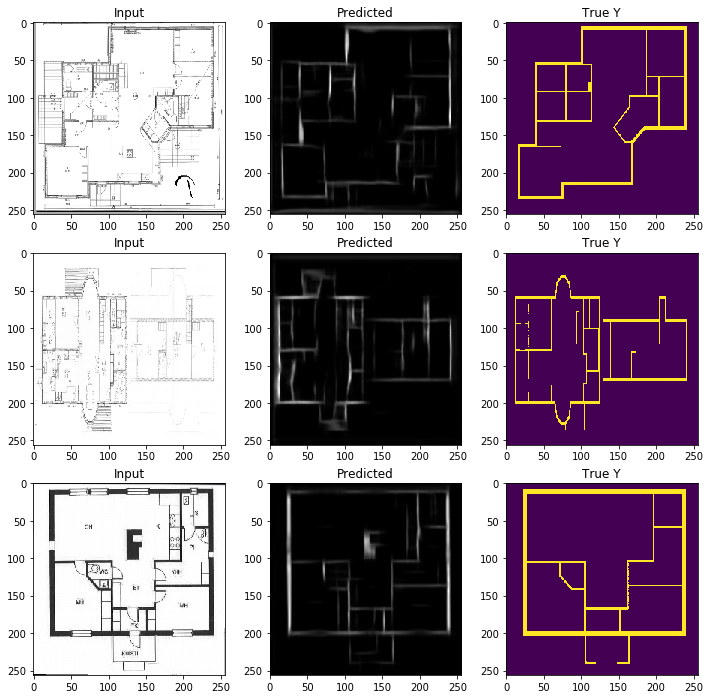

In [14]:
fig, ax = plt.subplots(3,3, figsize=(12,12))
for i in range(0,3):
    ax[i][0].imshow(sub_x_test[i])
    ax[i][0].set_title("Input");
    ax[i][1].imshow(pred[i],cmap='gray')
    ax[i][1].set_title("Predicted");
    ax[i][2].imshow(sub_y_test[i])
    ax[i][2].set_title("True Y");

The training process has pretty low accuracy since with output pixel is not strictly 0 and 1, we decide to turn them into 0/1 with a given threshold.

In [15]:
def post_process(pred, threshold = 0.25):
    return ((pred - pred.min())/pred.max() > threshold).astype(int)

Here, we show a few images of input, post-processed output, ground truth images.

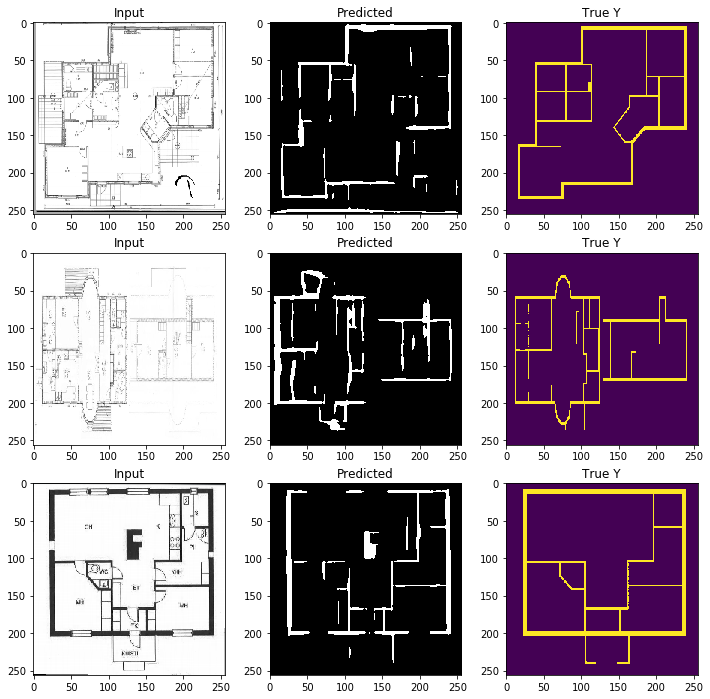

In [16]:
fig, ax = plt.subplots(3,3, figsize=(12,12))
for i in range(0,3):
    ax[i][0].imshow(sub_x_test[i])
    ax[i][0].set_title("Input");
    ax[i][1].imshow(post_process(pred[i], 0.15),cmap='gray')
    ax[i][1].set_title("Predicted");
    ax[i][2].imshow(sub_y_test[i])
    ax[i][2].set_title("True Y");

The exact accuracy for training and test set is printed below. The accuracy is around 93% for both training and test set, it looks pretty good.

In [17]:
#check accuracy for each test image
accuracy_list = []
for i in range(sub_x_test.shape[0]):
    post_img = post_process(pred[i])
    accuracy_list.append(np.mean(post_img == sub_y_test[i] ))
print('The average accuracy on the test set is: {}'.format(sum(accuracy_list)/len(accuracy_list)))

pred = model.predict(sub_x_train)
accuracy_list = []
#check accuracy for each training image
for i in range(sub_x_train.shape[0]):
    post_img = post_process(pred[i])
    accuracy_list.append(np.mean(post_img == sub_y_train[i] ))

print('The average accuracy on the training set is: {}'.format(sum(accuracy_list)/len(accuracy_list)))

The average accuracy on the test set is: 0.9309414672851563
The average accuracy on the training set is: 0.930584208170573


## Room Type Prediction

Our room type prediction model takes in a floorplan image and produces a semantic map where each pixel is assigned a class indicating its room type or being not a room.

We group the room types into 7 major categories:

In [2]:
# Mappings between room type, class label, and color for visualization
room2class = read_room2class_condensed("room_types_succinct.txt")
class2room = {v: k for k, v in room2class.items()}
class2color = get_class2color(max(room2class.values())+1)
n_classes = max(room2class.values())+1

print(list(class2label.values()))

['Empty', 'Entry', 'Outdoor', 'Bathroom', 'Kitchen', 'Livingroom', 'Bedroom', 'Others']


The input image is the same as in the model for wall prediction, while we extract the room type target semantic map from the `svg` file as a preprocessing step. The pipeline for this is as follows:

1. Create a blank 2D array of the same shape as the input image (256 x 256), which we refer to as the semantic map.
2. Read the polygon shapes of each room from the `svg` file.
3. Fill the pixels in the semantic map with the class labels of each polygon room.
4. Apply `to_categorical` to the semantic map to expand it into a 3D array for classification training.


The semantic map of an example floor plan is shown below, overlayed on the input image.

In [3]:
# Load preprocessed data
dataset_dir = "./data/cubicasa5k"

train_X = np.load(dataset_dir + "/train_inputs.npy")
train_y = np.load(dataset_dir + "/train_labels.npy")
train_y = to_categorical(train_y, num_classes=n_classes, dtype=np.int8)
val_X = np.load(dataset_dir + "/val_inputs.npy")
val_y = np.load(dataset_dir + "/val_labels.npy")
val_y = to_categorical(val_y, num_classes=n_classes, dtype=np.int8)

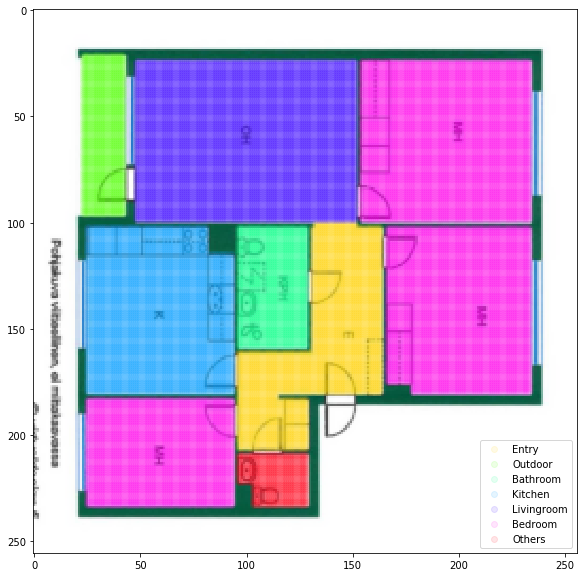

In [4]:
# Display an example semantic segmentation
idx = 5
input_example = val_X[idx]
label_example = val_y[idx]
FloorplanSVG.show_map(np.argmax(label_example, axis=-1), input_example, class2color, class2room)

The neural network model is very similar to the one for the wall prediction (U-net) except for the linear activation for the 2nd-to-last layer, and that last layer produces an array with `n_classes` channels.

In [5]:
# Neural network model for room type prediction
input_layer = Input(shape=INPUT_SHAPE)

#encoder
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
conv1 = Dropout(0.2)(conv1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Dropout(0.2)(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)

#decoder
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Dropout(0.2)(conv3)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

up1 = concatenate([UpSampling2D((2, 2))(conv3), conv2], axis=-1)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
conv4 = Dropout(0.2)(conv4)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)

up2 = concatenate([UpSampling2D((2, 2))(conv4), conv1], axis=-1)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
conv5 = Dropout(0.2)(conv5)
conv5 = Conv2D(32, (3, 3), activation='linear', padding='same')(conv5)


out = Conv2D(n_classes, (1, 1) , padding='same', activation=tf.nn.softmax)(conv5)


model = Model(input_layer ,out, name = 'U-net')

loss = tf.keras.losses.categorical_crossentropy
opt = Adam(lr = 0.001)
model.compile(loss= loss, optimizer=opt, metrics = ['accuracy'])
model.summary()

Model: "U-net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        dropout[0][0]                    
______________________________________________________________________________________________

In [7]:
# Load trained model weights
model.load_weights("saved_models/room_type_model_1_weights.h5")

After training for 96 epochs, we achieved an accuracy of ~63% on the validation set. 

Outputs for some example inputs from validation set are shown below, along with groundtruths:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


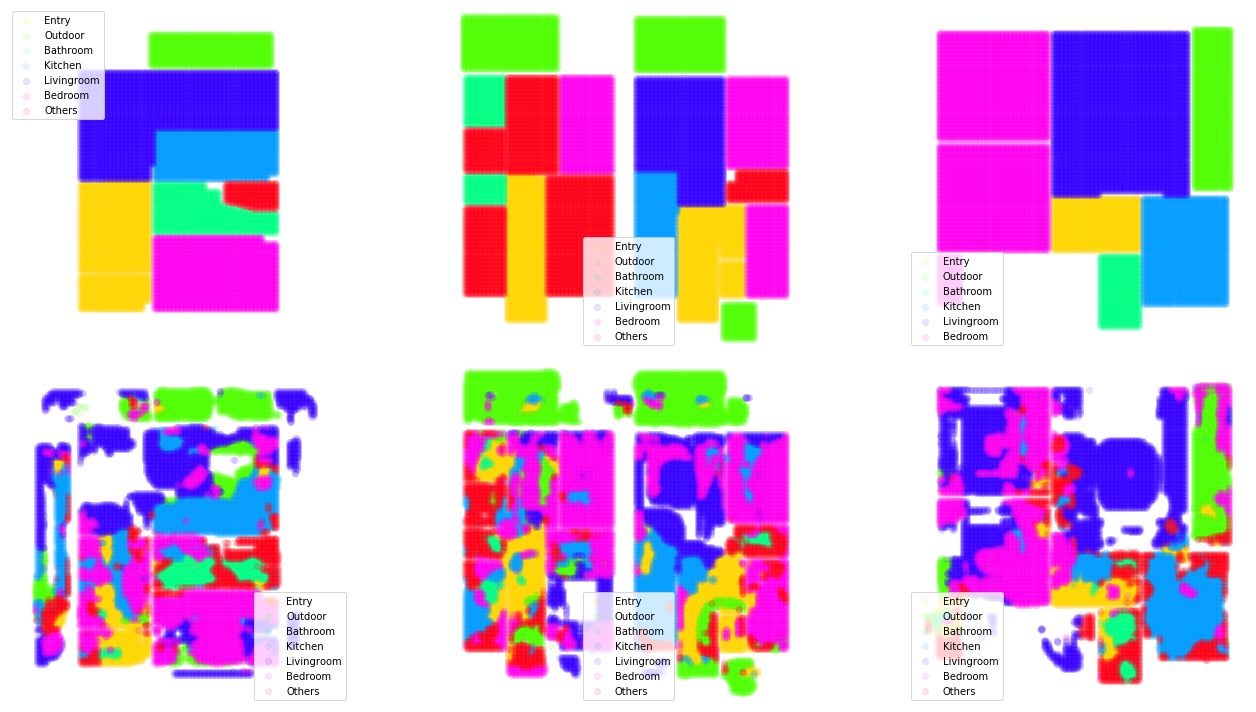

In [14]:
# Display output semantic map for the example inputs
indices = np.random.choice(range(len(val_X)), 3)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
for i, idx in enumerate(indices):
    trial = val_X[idx]
    result = model.predict(np.expand_dims(trial, axis=0))[0]
    FloorplanSVG.show_map(np.argmax(val_y[idx], axis=-1), 255*np.ones_like(trial), class2color, class2room, ax=axes[0, i])
    FloorplanSVG.show_map(np.argmax(result, axis=-1), 255*np.ones_like(trial), class2color, class2room, ax=axes[1, i])
plt.tight_layout()

The above results show that the overall floor plan structure has been recovered and the room types have been identified yet they are sometimes inconsistent with each other within each room, which brings us to the next section.

## Innovation - Room Type Consistency

As we can see in the previous part, when we predict the room type for every pixel of the graph, we are not utilizing the information that pixels close to each others should usually have the same label (if they are in the same room). Thus, in this section, we want to explore how knowing the positions of walls can help predict room types. 

Here we present an example of a wall image where we know the wall positions. The scaled image is shown besides too.

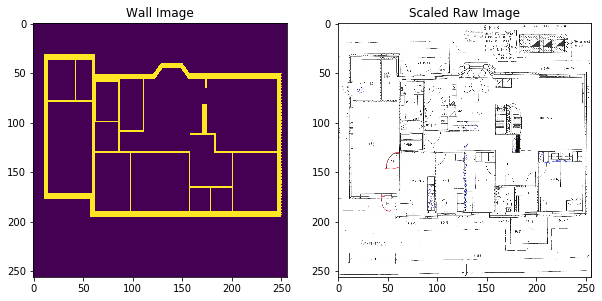

In [15]:
train_path='./cubicasa5k/train.txt' 
data_path=['./cubicasa5k'+i for i in np.genfromtxt(train_path,dtype='str')]
test=data_path[10]
x=extract_wall(test)
plt.figure(figsize = (10,8))
plt.subplot(1,2,1)
plt.imshow(x[1])
plt.title('Wall Image')
plt.subplot(1,2,2)
plt.imshow(x[0])
_ = plt.title('Scaled Raw Image')

Then we use image processing tools to extract the room positions by flipping the values of the wall images. Notice that we also dilate the walls before we do the flip so that the new mask is slightly smaller than the actual spaces. This step is performed because we don't want to have our mask cover the walls, which is not our main concern in predicting room types correctly. We then also set the parts outside walls to zeros. This part is not performed very strictly. We also label these room chunks for future use.

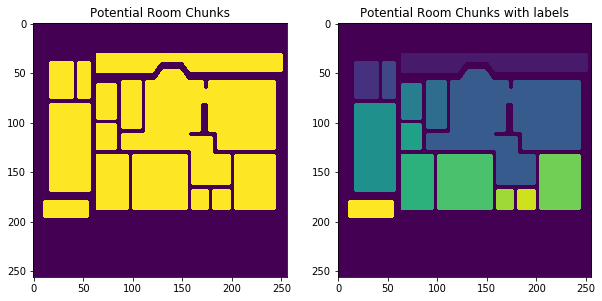

In [19]:
mask = ndimage.binary_dilation(x[1]).astype(np.float32)
mask = np.ones((256,256)) - mask

mask1 = mask.copy()
row = np.any(mask1==0,axis = 1)==1
col = np.any(mask1==0,axis = 0)==1
row1 = np.array([row]*256).transpose().astype(np.int8)
col1 = np.array([col]*256).astype(np.int8)
mask1 = np.floor((row1+col1)/2)

mask2 = np.floor((mask + mask1)/2)
mask2 = ndimage.binary_erosion(mask2).astype(np.float32)
mask2 = ndimage.binary_dilation(mask2).astype(np.float32)

mask2_3d = np.array([mask2]*3)
mask2_3d = mask2_3d.transpose((1, 2, 0))

plt.figure(figsize = (10,8))
plt.subplot(1,2,1)
plt.imshow(mask2)
plt.title('Potential Room Chunks')
plt.subplot(1,2,2)
labels = measure.label(mask2)
plt.imshow(labels)
_ = plt.title('Potential Room Chunks with labels')

Then we used this method to create numpy arrays saving these masks, using the code below.

In [ ]:
data_path = data_path1
Y=np.empty((len(data_path),256,256))
for i in range(len(data_path)):
    if i %100==0:
        print(i)
    x=extract_wall(data_path[i])
    
    mask = ndimage.binary_dilation(x[1]).astype(np.float32)
    mask = np.ones((256,256)) - mask

    mask1 = mask.copy()
    row = np.any(mask1==0,axis = 1)==1
    col = np.any(mask1==0,axis = 0)==1
    row1 = np.array([row]*256).transpose().astype(np.int8)
    col1 = np.array([col]*256).astype(np.int8)
    mask1 = np.floor((row1+col1)/2)

    mask2 = np.floor((mask + mask1)/2)
    mask2 = ndimage.binary_erosion(mask2).astype(np.float32)
    mask2 = ndimage.binary_dilation(mask2).astype(np.float32)
    labels = measure.label(mask2)

    Y[i] = labels

    
outfile = './saved_arrays/train_label.npy'
np.save(outfile, Y)

Our plan for the next step is to add a loss function to our model that measures the difference between pixels that are close to each other. We have written the code that expresses our goal but haven't included it to the model we used in the previous part yet.

In [25]:
rand_out = np.random.randint(0,4,size = (256,256))
test = to_categorical(rand_out) # test is a made-up image that mimic the form of our output, it's of shape(256,256,num_classes)
mask = labels # This is the mask transfered into the model with inputs

In [33]:
# test is final output layer
# mask is input mask
# alpha is weight of added loss

back = np.argmax(test,axis = 2)
back_down = np.roll(back,1,axis = 0)
back_down[0,:] = 0
back_right = np.roll(back,1)
back_right[:,0] = 0
num_class = back.max()+1

out_mask = tf.constant(to_categorical(back * (mask>0),num_classes = num_class))
out_down_mask = tf.constant(to_categorical(back_down * (mask>0),num_classes = num_class))
out_right_mask = tf.constant(to_categorical(back_right * (mask>0),num_classes = num_class))

new_loss =  tf.keras.backend.categorical_crossentropy(out_mask,out_down_mask) + tf.keras.backend.categorical_crossentropy(out_mask,out_right_mask)

# model.add_loss(alpha *new_loss)
np.mean(new_loss)

11.486997

As shown here, we are basically adding a new layer that calculates the cross entropy for each pixel in the output graph with the pixels right below it and right next to it on right. We do so by shifting the output graph down by one pixel and then applying the mask on it, setting all values outside the mask to 0 as they are not our concern. We then calculate the pixel-wise cross-entropy of this graph and the original output that also has the mask applied. Now the pixels not of our concern will not affect our results as they are set to have the same labels of 0s. Then we want to add this loss to the model with an alpha as weighting parameter. 

This part needs to be further adjusted to ensure the correctness of data types before we place it into the model, and we also need to test different alpha values so that the new model could work. We haven't tested this part as training other models took almost all our time, but it would be interesting to see how this additional part might improve the model performance.


## Conclusion

In this project, we mainly explored the use of segmentation models in performing tasks such as predicting wall positions and room types. While the paper used pipelined multi-task neural networks to perform these functions, our models have less complex structures. The performances of these models are not bad, especially for we know there’s still space for improvement by adjusting parameters and training for more epoches, though not surprisingly we find the results if these not as good as the paper. We also propose an innovative way in incorporating information from results of one model to the other, which might be useful in other cases when partial information is provided with the raw images.
